# Fit multiple potential SNIa with `sncosmo`

Import packages.

In [1]:
import sncosmo
import iminuit
import numpy as np

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define the  model for `sncosmo`.

In [2]:
model = sncosmo.Model(source='salt2')

Read in the nightly epoch lightcurves for all "good" candidates from 2021.

In [3]:
path = '../transients_science/all_candidate_nightly_epochs_files/'
fnm = path + 'candidate_lightcurves.dat'
candLC_field   = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid  = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd     = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter  = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj    = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag     = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage    = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb     = np.loadtxt(fnm, dtype='float', usecols=(8))
# candLC_maglim  = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

Read in the list of candidate IDs for potential SNIa that Melissa made with the MLG_snia_menagerie.ipynb notebook.

In [4]:
# path = '../extragalactic_fields/science_with_candidates/MLG_snia_menagerie_files/'
path = '../transients_science/'
fnm = path + 'potential_snia_list.dat'
potSNIa_candid = np.loadtxt(fnm, dtype='str', usecols=(0))
del fnm

In [5]:
print(potSNIa_candid)

['DC21bkrj' 'DC21bpls' 'DC21cgfhs' 'DC21cgfrp' 'DC21cgfui' 'DC21cozcn'
 'DC21cpcjp' 'DC21cwtlp' 'DC21cwtvj' 'DC21cwxin' 'DC21cyddn' 'DC21dglus'
 'DC21dhgr' 'DC21dix' 'DC21djbfp' 'DC21dna' 'DC21dqik' 'DC21drcko'
 'DC21drcmp' 'DC21drcum' 'DC21dslz' 'DC21dsocp' 'DC21dtwb' 'DC21eqq'
 'DC21eqtm' 'DC21fber' 'DC21hpdc' 'DC21ifio' 'DC21jfcb' 'DC21jof'
 'DC21ktp' 'DC21mjrj' 'DC22duvcm' 'DC22earrc' 'DC22eawkf' 'DC22gtccc'
 'DC22gtdsi' 'DC22gtqyk' 'DC22guhrf' 'DC22gvcqm' 'DC22hvtap' 'DC22hvtet'
 'DC22hvtwp' 'DC22hvuhl' 'DC22hvuzr' 'DC22hxfpz' 'DC22icaog' 'DC22ikidc'
 'DC22irwfh' 'DC22isyfm' 'DC22iteny' 'DC22iykha' 'DC22jbqyi' 'DC22jcvsy'
 'DC23jjloo' 'DC23jmrgj' 'DC23jpbgx' 'DC23jpvpn' 'DC23jqwvi' 'DC23jsner'
 'DC23jxtzq']


Define arrays to hold their fit results.

In [6]:
fit_z   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ze  = np.zeros(len(potSNIa_candid), dtype='float') 
fit_t0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_t0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1e = np.zeros(len(potSNIa_candid), dtype='float')
fit_c   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ce  = np.zeros(len(potSNIa_candid), dtype='float')

Run `sncosmo` for just 5 of the potential SNIa for now.

In [7]:
for c in range(5):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')
    
    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':(0.3, 0.7)})
    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']
    

See how the results arrays are populated.

In [8]:
print(fit_z)

[0.3748727  0.56327755 0.34555398 0.35238381 0.30958543 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


Yup OK, looks like the basic process above is going to work OK.

**TO DO!!**

Add a step to the fitting process abobe that involves estimating the likely redshift range for the SNIa from its peak brightness, and then using that smaller range for the boundaries in the `sncosmo.fit_lc()` command.

Then do the fit for ALL the potential SNIa, not just 5.

Then, explore their results. You can make plots of the distributions of values, compare relations between values, look at which potential SNIa have big errors. 

**UPDATE**

When collecting DDF data, we don't always capture the peak brightness of the SNe (e.g. just the decline). This thus underestimates the peak and affects the estimated redshift we initially wanted to calculate. Taking this into consideration, we will no longer be estimating the likely redshift range for each candidate using their peak brightnesses, but rather using a fixed range, z = 0.05 to z = 0.5. 
___

## Running `sncosmo` for potential SNIa candidates from all years

In [9]:
# Check number of potential candidates
len(potSNIa_candid)

61

In [10]:
# These candidates did not run through sncosmo without errors
new_potSNIa_candid = np.delete(potSNIa_candid, [20,52,53,54,55,56,57,58,59,60])

In [11]:
for i in [20,52,53,54,55,56,57,58,59,60]:
    print(potSNIa_candid[i])

DC21dslz
DC22jbqyi
DC22jcvsy
DC23jjloo
DC23jmrgj
DC23jpbgx
DC23jpvpn
DC23jqwvi
DC23jsner
DC23jxtzq


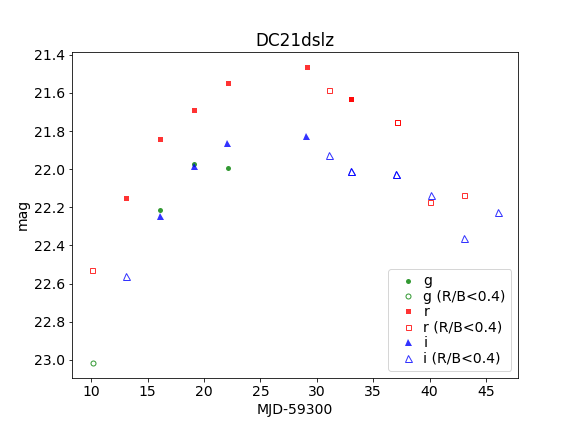

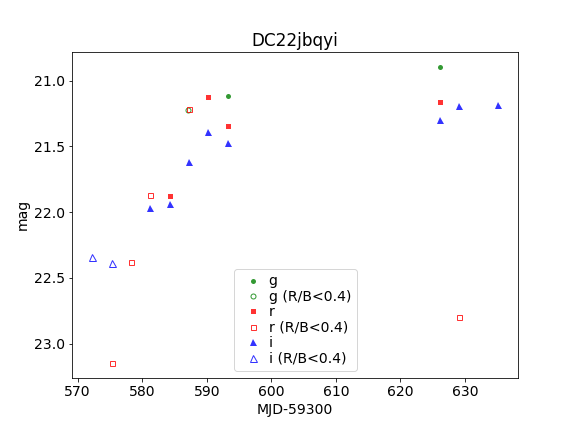

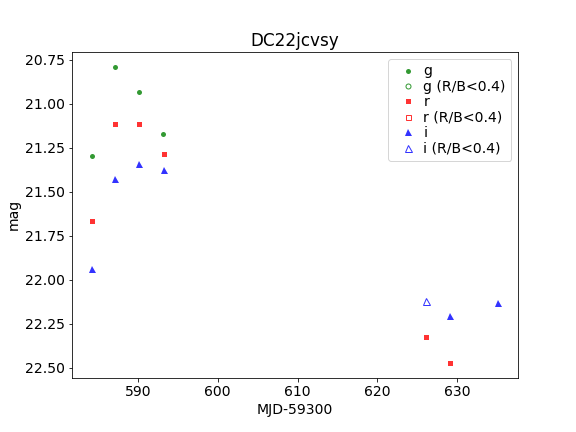

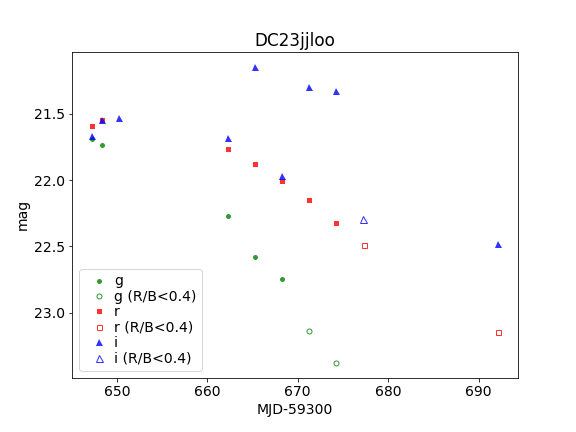

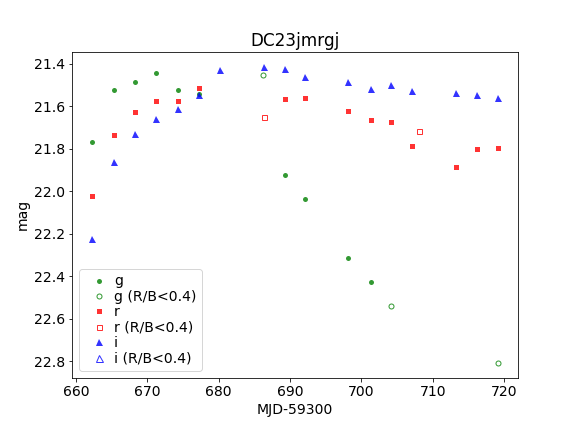

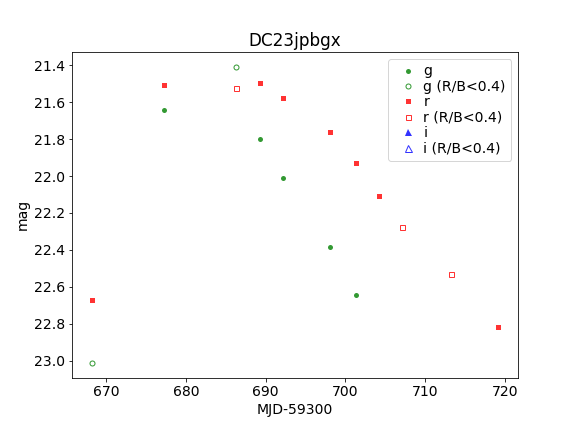

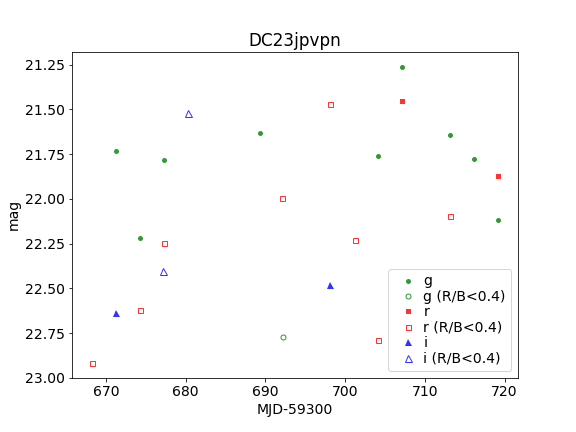

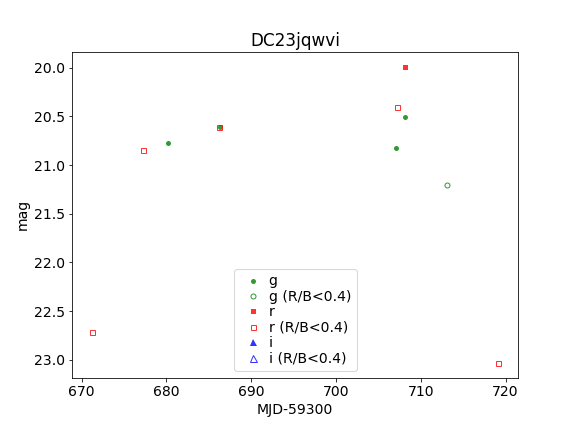

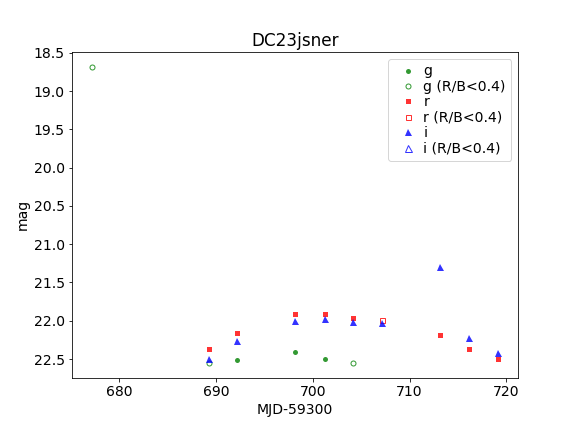

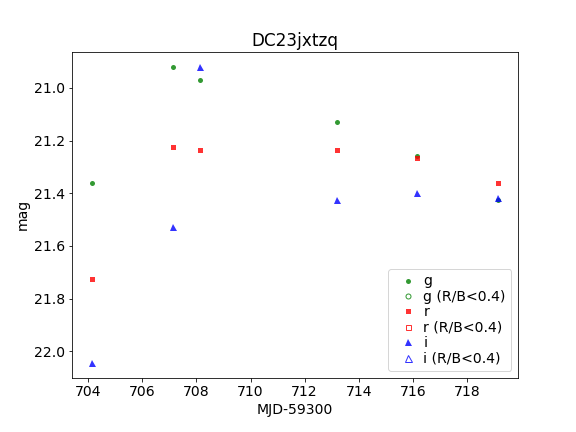

In [12]:
from IPython.display import display, Image
for i in [20,52,53,54,55,56,57,58,59,60]:
    image = Image(filename='../transients_science/all_potential_snia_plots/'+potSNIa_candid[i]+'.png',width=450)
    display(image)

In [13]:
len(new_potSNIa_candid)

51

In [14]:
# Create new arrays to hold parameters and errors

# fit_z   = np.zeros(len(new_potSNIa_candid), dtype='float')
# fit_ze  = np.zeros(len(new_potSNIa_candid), dtype='float') 
# fit_t0  = np.zeros(len(new_potSNIa_candid), dtype='float')
# fit_t0e = np.zeros(len(new_potSNIa_candid), dtype='float')
# fit_x0  = np.zeros(len(new_potSNIa_candid), dtype='float')
# fit_x0e = np.zeros(len(new_potSNIa_candid), dtype='float')
# fit_x1  = np.zeros(len(new_potSNIa_candid), dtype='float')
# fit_x1e = np.zeros(len(new_potSNIa_candid), dtype='float')
# fit_c   = np.zeros(len(new_potSNIa_candid), dtype='float')
# fit_ce  = np.zeros(len(new_potSNIa_candid), dtype='float')

#### Run `sncosmo` 

In [15]:
%%time

for c in range(len(potSNIa_candid)):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')
    
    # estimate z_range specific to each SNIa
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

    z_range_offset = 0.1
    z_range_min = estimated_redshift-z_range_offset
    z_range_max = estimated_redshift+z_range_offset
    z_range = (z_range_min, z_range_max)
    
    # result, fitted_model = sncosmo.fit_lc(data, model,
    #                                       ['z', 't0', 'x0', 'x1', 'c'],
    #                                       bounds={'z':(0.06,0.5)})
    
    result, fitted_model = sncosmo.fit_lc(data, model,
                                        ['z', 't0', 'x0', 'x1', 'c'],
                                        bounds={'z':z_range})

    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']

/global/homes/m/midorr/.local/cori/3.9-anaconda-2021.11/lib/python3.9/site-packages/sncosmo/models.py:813: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/global/homes/m/midorr/.local/cori/3.9-anaconda-2021.11/lib/python3.9/site-packages/sncosmo/models.py:812: RuntimeWarning: invalid value encountered in multiply
  return (self._parameters[0] * (m0 + self._parameters[1] * m1) *


RuntimeError: result is NaN for [ 0.235873 59356.5 -2.62419e+08 -48.9843 -3756.8 ]

Check that the result arrays are fully populated

In [114]:
fit_z

array([0.15821222, 0.25649188, 0.34554246, 0.23106693, 0.33508837,
       0.31681766, 0.37215537, 0.40127245, 0.26799754, 0.18078687,
       0.25528494, 0.37694539, 0.2249897 , 0.12918004, 0.51649638,
       0.18347495, 0.14020228, 0.34419527, 0.18732729, 0.37577983,
       0.12701858, 0.26372962, 0.32513553, 0.36193068, 0.27600774,
       0.26760109, 0.34510221, 0.33201356, 0.41143893, 0.22282576,
       0.11491502, 0.22208967, 0.30047629, 0.11991   , 0.37259435,
       0.34713726, 0.2359052 , 0.16473364, 0.26009369, 0.33584438,
       0.40281456, 0.19633491, 0.35996801, 0.28939721, 0.22019243,
       0.32075519, 0.19798261, 0.5334512 , 0.28782247, 0.32194741,
       0.12427329])

## Analyzing the results

In [115]:
import matplotlib.pyplot as plt

### Looking at the fit parameter & error distributions

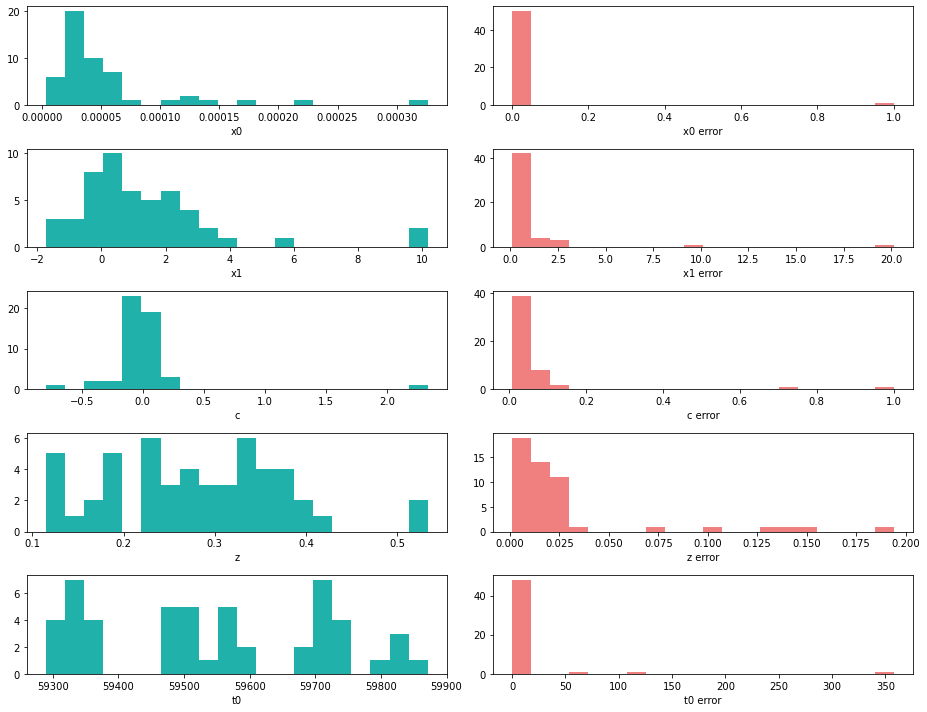

In [116]:
fig, ax = plt.subplots(5, 2)### Looking at the fit parameter distributions
fig.set_size_inches(13, 10)
# fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,0].set_xlabel('x0')

ax[0,1].hist(fit_x0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,1].set_xlabel('x0 error')

ax[1,0].hist(fit_x1, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,0].set_xlabel('x1')

ax[1,1].hist(fit_x1e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,1].set_xlabel('x1 error')

ax[2,0].hist(fit_c, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[2,0].set_xlabel('c')

ax[2,1].hist(fit_ce, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[2,1].set_xlabel('c error')

ax[3,0].hist(fit_z, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[3,0].set_xlabel('z')

ax[3,1].hist(fit_ze, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[3,1].set_xlabel('z error')

ax[4,0].hist(fit_t0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[4,0].set_xlabel('t0')

ax[4,1].hist(fit_t0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[4,1].set_xlabel('t0 error')

fig.tight_layout()
fig.show()

### Finding candidates with outlying parameter values & large errors

We're making the bounds for x1 to be about -5 to 5 and c to be about -0.5 to 0.5

In [117]:
# Find candidates associated w/ outlying x0 values
print(np.where(fit_x0 > 0.00007))

# Find candidates associated w/ outlying x1 values
print(np.where(fit_x1 > 2))

# Find candidates associated w/ outlying c values
print(np.where(fit_c < -0.5))

# Find candidates associated w/ outlying c values
print(np.where(fit_c > 0.5))

# Find candidates associated w/ outlying z values
print(np.where(fit_z > 0.45))

# Find candidates associated w/ large x0 errors
print(np.where(fit_x0e > 0.2))

# Find candidates associated w/ large x1 errors
print(np.where(fit_x1e > 3))

# Find candidates associated w/ large c errors
print(np.where(fit_ce > 0.2))

# Find candidates associated w/ large z errors
print(np.where(fit_ze > 0.05))

# Find candidates associated w/ large t0 errors
print(np.where(fit_t0e > 10))

(array([15, 20, 30, 33, 37, 40, 46, 50]),)
(array([ 5, 12, 13, 23, 25, 28, 34, 35, 36, 38, 39, 42, 45, 47, 49]),)
(array([11]),)
(array([49]),)
(array([14, 47]),)
(array([39]),)
(array([15, 30]),)
(array([30, 39]),)
(array([ 4, 15, 30, 39, 47, 48]),)
(array([15, 30, 39]),)


So, we should expect candidates associated with these indices to have bad fits from `sncosmo`. 

> 4, 5, 11, 12, 13, 14, 15, 20, 23, 25, 28, 30, 33, 34, 35, 36, 37, 38, 39, 40, 42, 45, 46, 47, 48, 49, 50

### Taking a look at some expected bad fits

#### Candidate 4

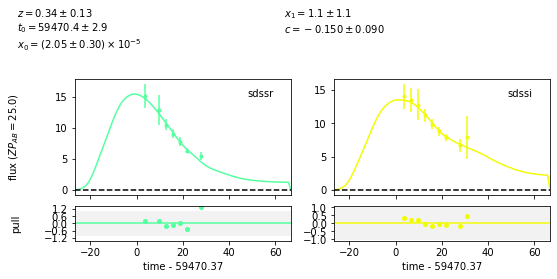

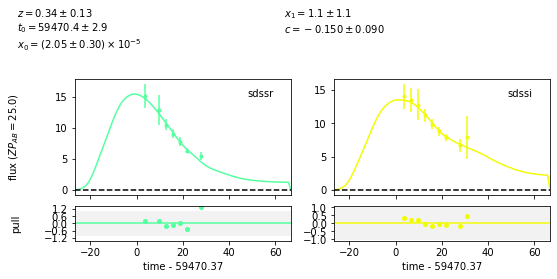

In [118]:
# define the candidate
my_potential_snia = (new_potSNIa_candid[4])

# identify the lightcurve points for this candidate
tx = np.where(candLC_candid == my_potential_snia)[0]

# write the lightcurve to a temporary file
fout = open('tempLC.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

del tx

# read the file with sncosmo
data = sncosmo.read_lc('tempLC.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range_min = estimated_redshift-z_range_offset
z_range_max = estimated_redshift+z_range_offset
z_range = (z_range_min, z_range_max)

result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

This candidate only has large z error, and the fit looks decent. Can note that this candidate looks to have only detected the decline, so peak brightness is underestimated, which affects estimated redshift we calculated for the redshift bounds.

#### Candidate 5

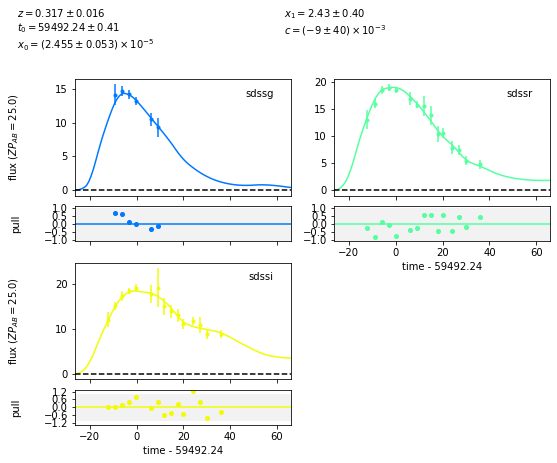

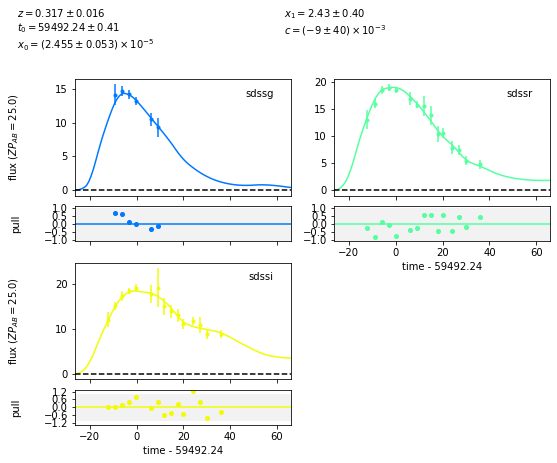

In [119]:
# define the candidate
my_potential_snia = (new_potSNIa_candid[5])

# identify the lightcurve points for this candidate
tx = np.where(candLC_candid == my_potential_snia)[0]

# write the lightcurve to a temporary file
fout = open('tempLC.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

del tx

# read the file with sncosmo
data = sncosmo.read_lc('tempLC.txt')

# estimate z_range specific to each SNIa
fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

z_range_offset = 0.1
z_range_min = estimated_redshift-z_range_offset
z_range_max = estimated_redshift+z_range_offset
z_range = (z_range_min, z_range_max)

result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

This one actually looks good.

In [120]:
len(new_potSNIa_candid)

51

### Creating a PDF of fits of all candidates

In [121]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('AllFitsNew.pdf')

for c in range((len(new_potSNIa_candid))):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == new_potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')

    # estimate z_range specific to each SNIa
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 300000.0 ## estimate redshift

    z_range_offset = 0.1
    z_range_min = estimated_redshift-z_range_offset
    z_range_max = estimated_redshift+z_range_offset
    z_range = (z_range_min, z_range_max)

    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range})
    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']
    
    sncosmo.plot_lc(data, model=fitted_model, errors=result.errors, model_label=potSNIa_candid[c], fname=pp, format='pdf')

pp.close()

/global/homes/m/midorr/.local/cori/3.9-anaconda-2021.11/lib/python3.9/site-packages/sncosmo/fitting.py:235: RuntimeWarning: divide by zero encountered in divide
  significant_data = data[(data.flux / data.fluxerr) > minsnr]
/global/homes/m/midorr/.local/cori/3.9-anaconda-2021.11/lib/python3.9/site-packages/sncosmo/plotting.py:429: RuntimeWarning: divide by zero encountered in divide
  fluxpulls = (flux - mflux) / fluxerr


### Removing bad fits

In [122]:
new_fit_x0 = np.delete(fit_x0, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)
new_fit_x0e = np.delete(fit_x0e, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)

new_fit_x1 = np.delete(fit_x1, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)
new_fit_x1e = np.delete(fit_x1e, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)

new_fit_c = np.delete(fit_c, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)
new_fit_ce = np.delete(fit_ce, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)

new_fit_z = np.delete(fit_z, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)
new_fit_ze = np.delete(fit_ze, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)

new_fit_t0 = np.delete(fit_t0, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)
new_fit_t0e = np.delete(fit_t0e, [4,5,11,12,13,14,15,20,23,25,28,30,33,34,35,36,37,38,39,40,42,45,46,47,48,49,50], 0)

### Converting $x_{1}$ into $\Delta m_{15B}$

$\Delta m_{15} = 1.09 - 0.161x_{1}+0.013x_{1}^{2}-0.00130x_{1}^{3}$ (From <a href="https://ui.adsabs.harvard.edu/abs/2007A%26A...466...11G/abstract"> Julien Guy's SALT2 paper </a>)

In [123]:
import uncertainties as unc  
import uncertainties.unumpy as unp

x1_with_unc = unp.uarray((new_fit_x1, new_fit_x1e))

/tmp/ipykernel_43136/3875243177.py:4: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  x1_with_unc = unp.uarray((new_fit_x1, new_fit_x1e))


In [124]:
delta_m15b=[]
for i in range(len(new_fit_x1)):
    delta_m15b.append(1.09 - (0.161*(x1_with_unc[i])) + (0.013*(x1_with_unc[i])**2) - (0.00130*(x1_with_unc[i])**3))
delta_m15b_e = unp.std_devs(delta_m15b)
delta_m15b_n = unp.nominal_values(delta_m15b)

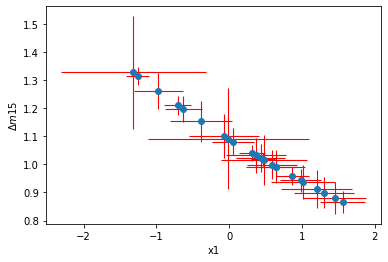

In [125]:
# Look at relationship between x1 and delta m15
# plt.scatter(new_fit_x1,delta_m15_n)
plt.errorbar(new_fit_x1,delta_m15b_n,xerr=new_fit_x1e,yerr=delta_m15b_e, fmt="o", elinewidth=1.1, ecolor="red")
plt.xlabel("x1")
plt.ylabel("$\Delta m15$");

### Converting $x_{0}$ into $m_{B}$
$m_{B} = −2.5\log(x_{0})+10.635$ (From <a href="https://arxiv.org/abs/1401.4065"> this paper </a>)

In [126]:
x0_with_unc = unp.uarray((new_fit_x0, new_fit_x0e))

/tmp/ipykernel_43136/3147248892.py:1: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  x0_with_unc = unp.uarray((new_fit_x0, new_fit_x0e))


In [127]:
mb=[]
for i in range(len(new_fit_x0)):
    mb.append((-2.5*unp.log10(x0_with_unc[i]))+10.635)
mb_e = unp.std_devs(mb)
mb_n = unp.nominal_values(mb)

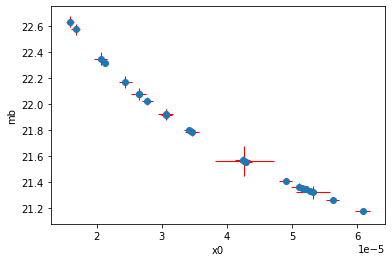

In [128]:
# Look at relationship between x0 and mb
#plt.scatter(new_fit_x0,mb_n)
plt.errorbar(new_fit_x0,mb_n,xerr=new_fit_x0e,yerr=mb_e, fmt="o", elinewidth=1.1, ecolor="red")
plt.xlabel("x0")
plt.ylabel("mb");

### Calculating $ M_{B}$

In [129]:
new_fit_z_min = new_fit_z - new_fit_ze
new_fit_z_max = new_fit_z + new_fit_ze

In [130]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

abs_mag_min=[]
abs_mag_max=[]
for i in range(len(new_fit_x0)):
    lum_dist_min = cosmo.luminosity_distance(new_fit_z_min[i])
    lum_dist_max = cosmo.luminosity_distance(new_fit_z_max[i])
    dist_mod_min = (5*np.log10(lum_dist_min.value))+25
    dist_mod_max = (5*np.log10(lum_dist_max.value))+25
    abs_mag_max.append(mb_n[i]-dist_mod_min)
    abs_mag_min.append(mb_n[i]-dist_mod_max)
abs_mage = (abs(np.array(abs_mag_min)-np.array(abs_mag_max)))/2
abs_mag = abs_mag_min+abs_mage # or abs_mag_max-abs_mage

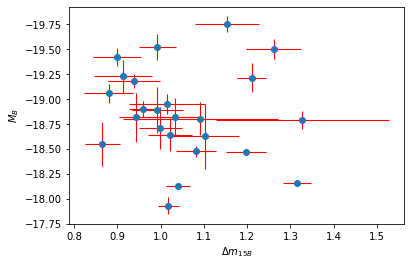

In [131]:
#plt.scatter(delta_m15b_n,abs_mag)
#plt.scatter(delta_m15b_n,abs_mag)
plt.errorbar(delta_m15b_n,abs_mag, xerr=delta_m15b_e, yerr=abs_mage, fmt="o", elinewidth=1.1, ecolor="red")
plt.xlabel("$\Delta m_{15B}$")
plt.ylabel("$M_{B}$")
plt.gca().invert_yaxis();

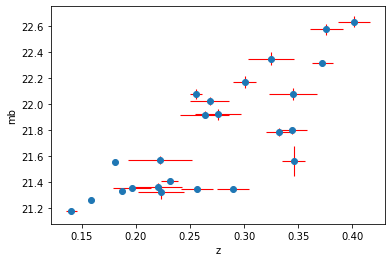

In [132]:
# plt.scatter(new_fit_z, mb)
plt.errorbar(new_fit_z, mb_n, xerr=new_fit_ze, yerr=mb_e, fmt="o",elinewidth=1.1, ecolor="red")
# plt.xlim(0,0.75)
# plt.ylim(19.75,23.25)
plt.xlabel('z')
plt.ylabel('mb');

### Comparing relations between parameters

#### Comparison between original parameters

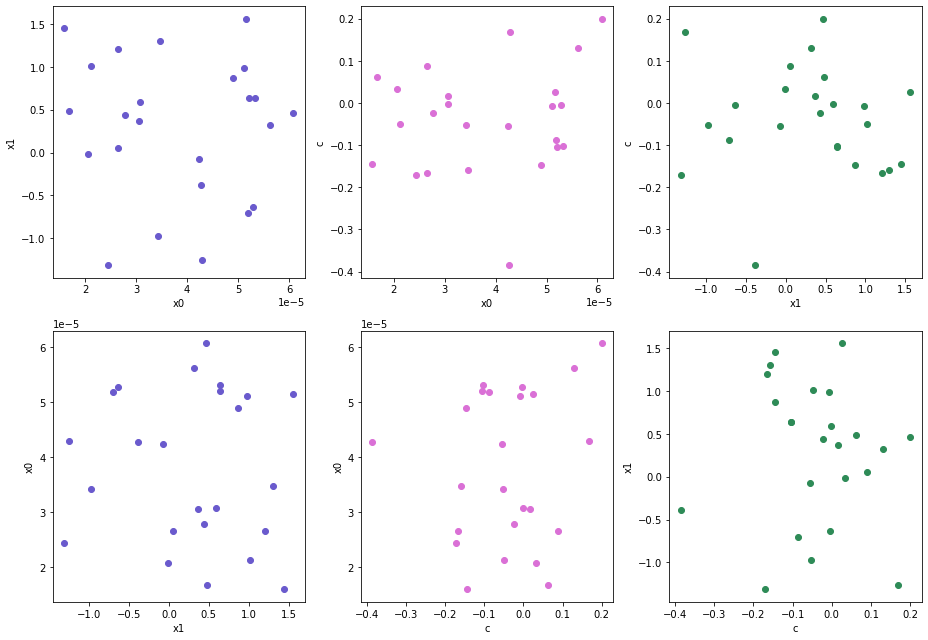

In [133]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(new_fit_x0, new_fit_x1, color='slateblue')
ax[0,0].set_xlabel('x0')
ax[0,0].set_ylabel('x1')

ax[0,1].scatter(new_fit_x0, new_fit_c, color='orchid')
ax[0,1].set_xlabel('x0')
ax[0,1].set_ylabel('c')

ax[0,2].scatter(new_fit_x1, new_fit_c, color='seagreen')
ax[0,2].set_xlabel('x1')
ax[0,2].set_ylabel('c')

ax[1,0].scatter(new_fit_x1, new_fit_x0, color='slateblue')
ax[1,0].set_xlabel('x1')
ax[1,0].set_ylabel('x0')

ax[1,1].scatter(new_fit_c, new_fit_x0, color='orchid')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel('x0')

ax[1,2].scatter(new_fit_c, new_fit_x1, color='seagreen')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel('x1')


fig.tight_layout()
fig.show()

#### Comparison between converted parameters

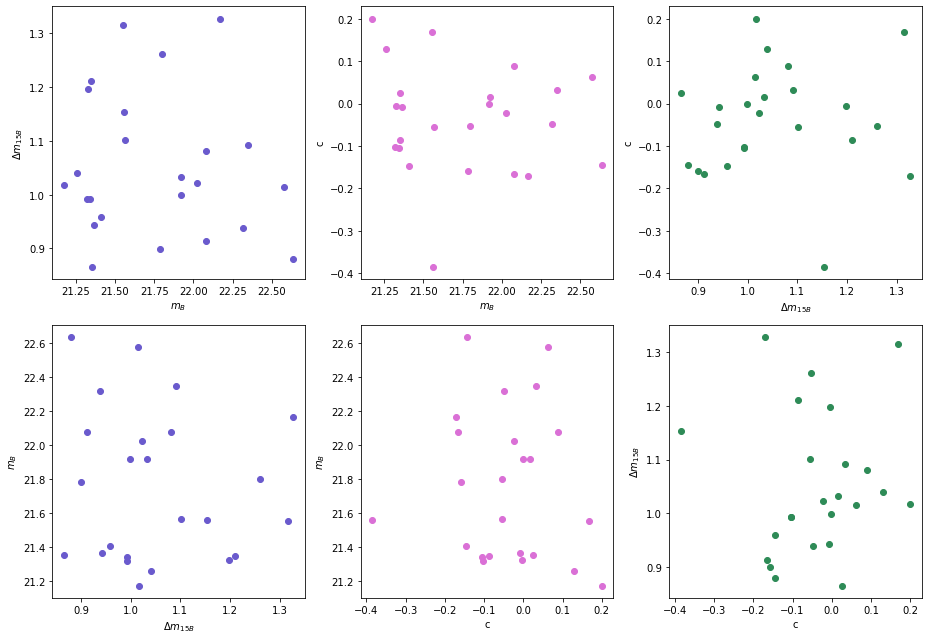

In [134]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(mb_n, delta_m15b_n, color='slateblue')
ax[0,0].set_xlabel("$m_{B}$")
ax[0,0].set_ylabel("$\Delta m_{15B}$")

ax[0,1].scatter(mb_n, new_fit_c, color='orchid')
ax[0,1].set_xlabel("$m_{B}$")
ax[0,1].set_ylabel('c')

ax[0,2].scatter(delta_m15b_n, new_fit_c, color='seagreen')
ax[0,2].set_xlabel("$\Delta m_{15B}$")
ax[0,2].set_ylabel('c')

ax[1,0].scatter(delta_m15b_n, mb_n, color='slateblue')
ax[1,0].set_xlabel("$\Delta m_{15B}$")
ax[1,0].set_ylabel("$m_{B}$")

ax[1,1].scatter(new_fit_c, mb_n, color='orchid')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel("$m_{B}$")

ax[1,2].scatter(new_fit_c, delta_m15b_n, color='seagreen')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel("$\Delta m_{15B}$")


fig.tight_layout()
fig.show()

#### Comparison between abs mag $M_{B}$, and original & converted parameters

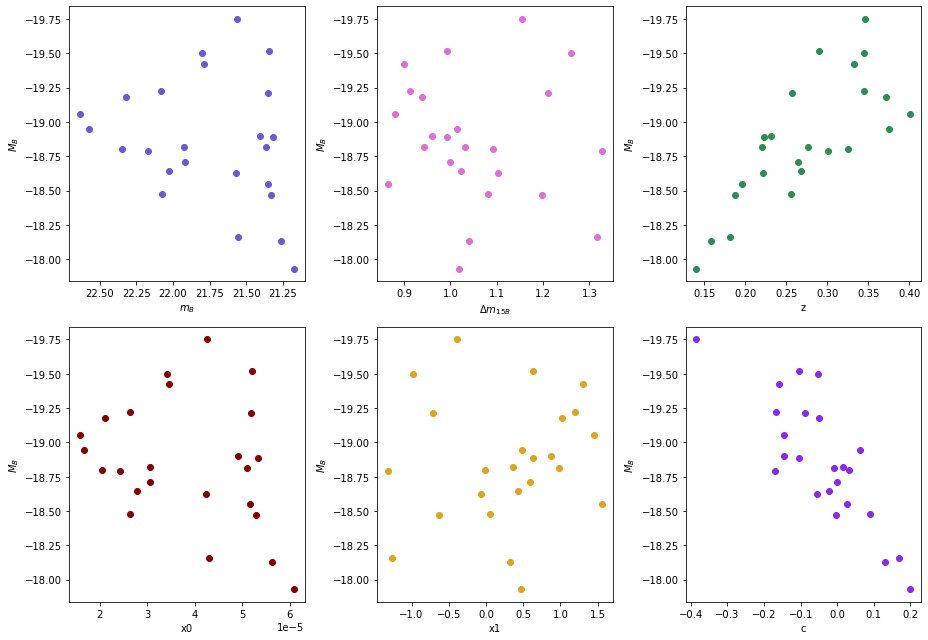

In [135]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(mb_n, abs_mag, color='slateblue')
ax[0,0].set_xlabel("$m_{B}$")
ax[0,0].set_ylabel("$M_{B}$")
ax[0,0].invert_yaxis()
ax[0,0].invert_xaxis()

ax[0,1].scatter(delta_m15b_n, abs_mag, color='orchid')
ax[0,1].set_xlabel("$\Delta m_{15B}$")
ax[0,1].set_ylabel("$M_{B}$")
ax[0,1].invert_yaxis()

ax[0,2].scatter(new_fit_z, abs_mag, color='seagreen')
ax[0,2].set_xlabel('z')
ax[0,2].set_ylabel("$M_{B}$")
ax[0,2].invert_yaxis()

ax[1,0].scatter(new_fit_x0, abs_mag, color='maroon')
ax[1,0].set_xlabel('x0')
ax[1,0].set_ylabel("$M_{B}$")
ax[1,0].invert_yaxis()

ax[1,1].scatter(new_fit_x1, abs_mag, color='goldenrod')
ax[1,1].set_xlabel('x1')
ax[1,1].set_ylabel("$M_{B}$")
ax[1,1].invert_yaxis()

ax[1,2].scatter(new_fit_c, abs_mag, color='blueviolet')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel("$M_{B}$")
ax[1,2].invert_yaxis()

fig.tight_layout()
fig.show();

### Rating the fits

After looking through the PDF of fits for all candidates, I have given them a rating of good, maybe, or bad.

>**Good**: sncosmo fits our data very well; our data captures both the rise and fall of the supernova; has typical parameter values w/out large errors

>**Maybe**: sncosmo fits our data somewhat well; not enough data/our data only captures the incline/decline of the supernova; may have abnormal parameter values & large errors; missing in a band

>**Bad**: sncosmo does not fit our data well; our data is bad/clearly not type 1a-like; has abnormal parameter values w/ large errors

In [150]:
good=[0,3,5,6,7,8,9,10,12,14,16,17,18,19,20,34,36,29,44,50]
maybe=[1,2,4,11,21,22,23,25,27,28,31,32,33,34,35,36,37,38,39,41,43,46,48] 
bad=[13,15,30,40,42,45,47,49] 

Most of the original list of bad fits based on parameter value & error also got a bad rating for the actual fit. 4 of the original bad were rated as maybe, and 1 original bad was actually rated as good.

Also note: candidates of these indices were not detected in all three bands: 3, 4, 10, 13, 22, 34, 48

None of them recieved a good rating, only bad & maybe.

In [139]:
good_x0=[]
good_x1=[]
good_c=[]
good_z=[]
good_t0=[]
good_x0e=[]
good_x1e=[]
good_ce=[]
good_ze=[]
good_t0e=[]

for i in good:
        good_x0.append(fit_x0[i])
        good_x1.append(fit_x1[i])
        good_c.append(fit_c[i])
        good_z.append(fit_z[i])
        good_t0.append(fit_t0[i])
        good_x0e.append(fit_x0e[i])
        good_x1e.append(fit_x1e[i])
        good_ce.append(fit_ce[i])
        good_ze.append(fit_ze[i])
        good_t0e.append(fit_t0e[i])
        
maybe_x0=[]
maybe_x1=[]
maybe_c=[]
maybe_z=[]
maybe_t0=[]
maybe_x0e=[]
maybe_x1e=[]
maybe_ce=[]
maybe_ze=[]
maybe_t0e=[]

for i in maybe:
        maybe_x0.append(fit_x0[i])
        maybe_x1.append(fit_x1[i])
        maybe_c.append(fit_c[i])
        maybe_z.append(fit_z[i])
        maybe_t0.append(fit_t0[i])
        maybe_x0e.append(fit_x0e[i])
        maybe_x1e.append(fit_x1e[i])
        maybe_ce.append(fit_ce[i])
        maybe_ze.append(fit_ze[i])
        maybe_t0e.append(fit_t0e[i])

bad_x0=[]
bad_x1=[]
bad_c=[]
bad_z=[]
bad_t0=[]
bad_x0e=[]
bad_x1e=[]
bad_ce=[]
bad_ze=[]
bad_t0e=[]

for i in bad:
        bad_x0.append(fit_x0[i])
        bad_x1.append(fit_x1[i])
        bad_c.append(fit_c[i])
        bad_z.append(fit_z[i])
        bad_t0.append(fit_t0[i])
        bad_x0e.append(fit_x0e[i])
        bad_x1e.append(fit_x1e[i])
        bad_ce.append(fit_ce[i])
        bad_ze.append(fit_ze[i])
        bad_t0e.append(fit_t0e[i])

### Plotting the rated distributions

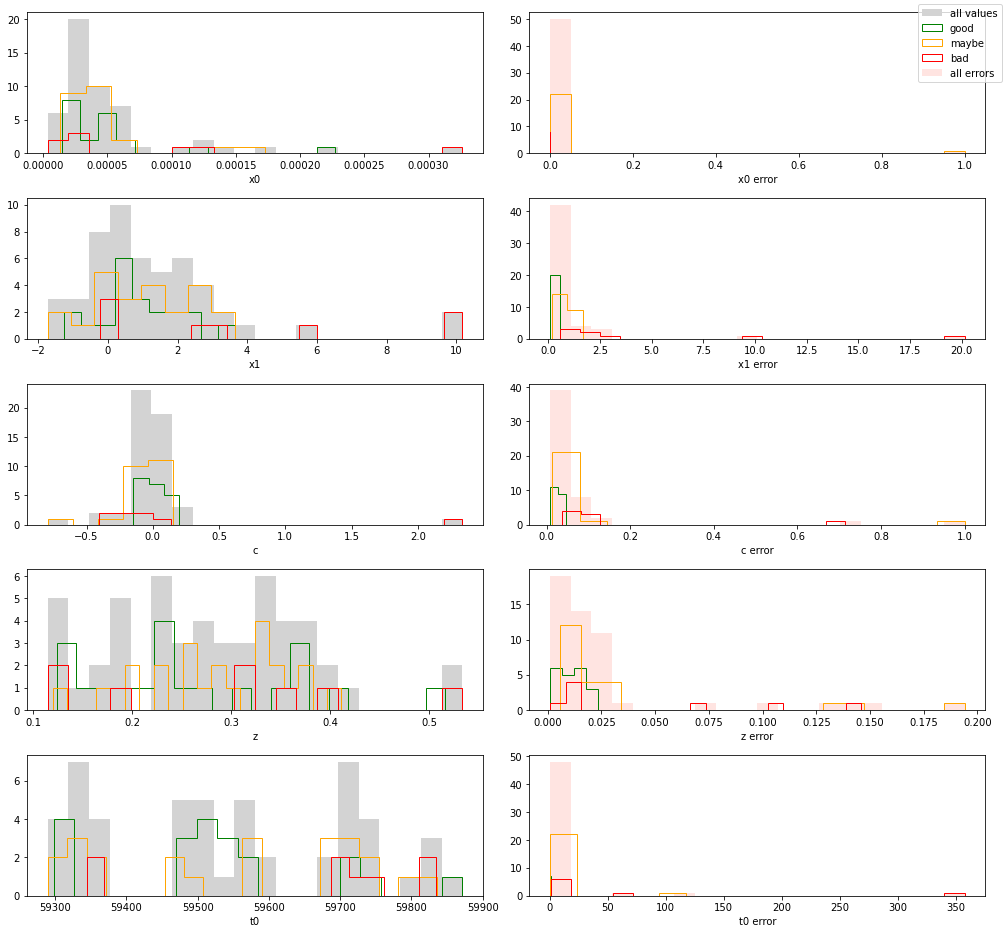

In [140]:
fig, ax = plt.subplots(5, 2)### Looking at the fit parameter distributions
fig.set_size_inches(14, 13)
# fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0, bins=20, density=False, histtype='stepfilled', color='lightgrey', label="all values")
ax[0,0].hist(good_x0, bins=15, density=False, histtype='step', color='green', label="good")
ax[0,0].hist(maybe_x0, bins=8, density=False, histtype='step', color='orange', label="maybe")
ax[0,0].hist(bad_x0, bins=20, density=False, histtype='step', color='red', label="bad")
ax[0,0].set_xlabel('x0')

ax[0,1].hist(fit_x0e, bins=20, density=False, histtype='stepfilled', color='mistyrose', label="all errors")
ax[0,1].hist(good_x0e, bins=1, density=False, histtype='step', color='green')
ax[0,1].hist(maybe_x0e, bins=20, density=False, histtype='step', color='orange')
ax[0,1].hist(bad_x0e, bins=1, density=False, histtype='step', color='red')
ax[0,1].set_xlabel('x0 error')

ax[1,0].hist(fit_x1, bins=20, density=False, histtype='stepfilled', color='lightgrey')
ax[1,0].hist(good_x1, bins=10, density=False, histtype='step', color='green')
ax[1,0].hist(maybe_x1, bins=8, density=False, histtype='step', color='orange')
ax[1,0].hist(bad_x1, bins=20, density=False, histtype='step', color='red')
ax[1,0].set_xlabel('x1')

ax[1,1].hist(fit_x1e, bins=20, density=False, histtype='stepfilled', color='mistyrose')
ax[1,1].hist(good_x1e, bins=1, density=False, histtype='step', color='green')
ax[1,1].hist(maybe_x1e, bins=2, density=False, histtype='step', color='orange')
ax[1,1].hist(bad_x1e, bins=20, density=False, histtype='step', color='red')
ax[1,1].set_xlabel('x1 error')

ax[2,0].hist(fit_c, bins=20, density=False, histtype='stepfilled', color='lightgrey')
ax[2,0].hist(good_c, bins=3, density=False, histtype='step', color='green')
ax[2,0].hist(maybe_c, bins=5, density=False, histtype='step', color='orange')
ax[2,0].hist(bad_c, bins=20, density=False, histtype='step', color='red')
ax[2,0].set_xlabel('c')

ax[2,1].hist(fit_ce, bins=20, density=False, histtype='stepfilled', color='mistyrose')
ax[2,1].hist(good_ce, bins=2, density=False, histtype='step', color='green')
ax[2,1].hist(maybe_ce, bins=15, density=False, histtype='step', color='orange')
ax[2,1].hist(bad_ce, bins=15, density=False, histtype='step', color='red')
ax[2,1].set_xlabel('c error')

ax[3,0].hist(fit_z, bins=20, density=False, histtype='stepfilled', color='lightgrey')
ax[3,0].hist(good_z, bins=20, density=False, histtype='step', color='green')
ax[3,0].hist(maybe_z, bins=20, density=False, histtype='step', color='orange')
ax[3,0].hist(bad_z, bins=20, density=False, histtype='step', color='red')
ax[3,0].set_xlabel('z')

ax[3,1].hist(fit_ze, bins=20, density=False, histtype='stepfilled', color='mistyrose')
ax[3,1].hist(good_ze, bins=4, density=False, histtype='step', color='green')
ax[3,1].hist(maybe_ze, bins=20, density=False, histtype='step', color='orange')
ax[3,1].hist(bad_ze, bins=20, density=False, histtype='step', color='red')
ax[3,1].set_xlabel('z error')

ax[4,0].hist(fit_t0, bins=20, density=False, histtype='stepfilled', color='lightgrey')
ax[4,0].hist(good_t0, bins=20, density=False, histtype='step', color='green')
ax[4,0].hist(maybe_t0, bins=20, density=False, histtype='step', color='orange')
ax[4,0].hist(bad_t0, bins=20, density=False, histtype='step', color='red')
ax[4,0].set_xlabel('t0')

ax[4,1].hist(fit_t0e, bins=20, density=False, histtype='stepfilled', color='mistyrose')
ax[4,1].hist(good_t0e, bins=2, density=False, histtype='step', color='green')
ax[4,1].hist(maybe_t0e, bins=5, density=False, histtype='step', color='orange')
ax[4,1].hist(bad_t0e, bins=20, density=False, histtype='step', color='red')
ax[4,1].set_xlabel('t0 error')

fig.tight_layout()
fig.legend()
fig.show()

### Recomparing relations between parameters w/ rated data

#### Comparison between original parameters w/ rated data

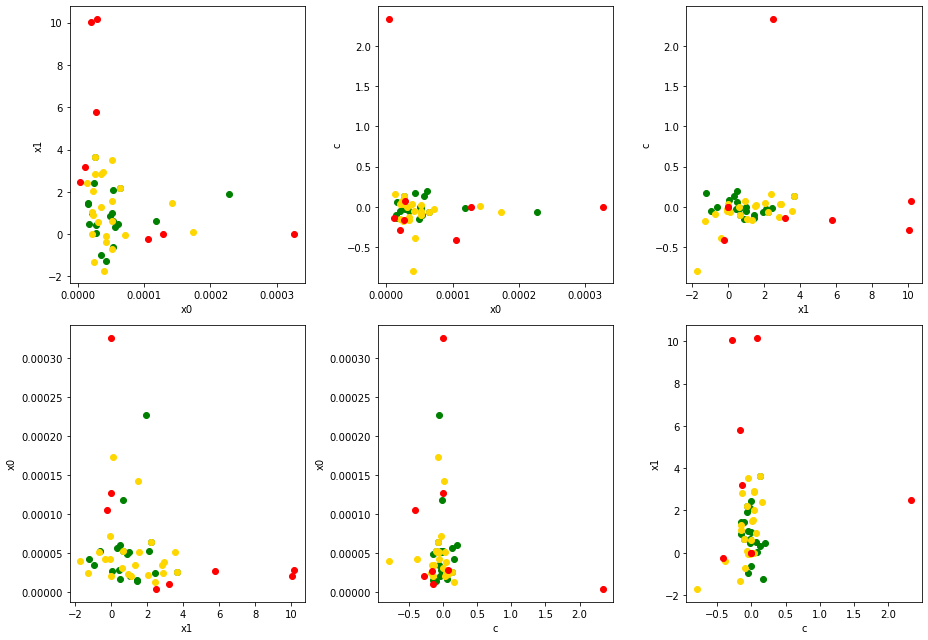

In [141]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(good_x0, good_x1, color='green')
ax[0,0].scatter(maybe_x0, maybe_x1, color='gold')
ax[0,0].scatter(bad_x0, bad_x1, color='red')
ax[0,0].set_xlabel('x0')
ax[0,0].set_ylabel('x1')

ax[0,1].scatter(good_x0, good_c, color='green')
ax[0,1].scatter(maybe_x0, maybe_c, color='gold')
ax[0,1].scatter(bad_x0, bad_c, color='red')
ax[0,1].set_xlabel('x0')
ax[0,1].set_ylabel('c')

ax[0,2].scatter(good_x1, good_c, color='green')
ax[0,2].scatter(maybe_x1, maybe_c, color='gold')
ax[0,2].scatter(bad_x1, bad_c, color='red')
ax[0,2].set_xlabel('x1')
ax[0,2].set_ylabel('c')

ax[1,0].scatter(good_x1, good_x0, color='green')
ax[1,0].scatter(maybe_x1, maybe_x0, color='gold')
ax[1,0].scatter(bad_x1, bad_x0, color='red')
ax[1,0].set_xlabel('x1')
ax[1,0].set_ylabel('x0')

ax[1,1].scatter(good_c, good_x0, color='green')
ax[1,1].scatter(maybe_c, maybe_x0, color='gold')
ax[1,1].scatter(bad_c, bad_x0, color='red')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel('x0')

ax[1,2].scatter(good_c, good_x1, color='green')
ax[1,2].scatter(maybe_c, maybe_x1, color='gold')
ax[1,2].scatter(bad_c, bad_x1, color='red')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel('x1')


fig.tight_layout()
fig.show()

#### Comparison between converted parameters w/ rated data

In [142]:
x1_with_unc = unp.uarray((fit_x1, fit_x1e))
delta_m15b=[]
for i in range(len(fit_x1)):
    delta_m15b.append(1.09 - (0.161*(x1_with_unc[i])) + (0.013*(x1_with_unc[i])**2) - (0.00130*(x1_with_unc[i])**3))
delta_m15b_e = unp.std_devs(delta_m15b)
delta_m15b_n = unp.nominal_values(delta_m15b)

/tmp/ipykernel_43136/309122676.py:1: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  x1_with_unc = unp.uarray((fit_x1, fit_x1e))


In [143]:
x0_with_unc = unp.uarray((fit_x0, fit_x0e))
mb=[]
for i in range(len(fit_x0)):
    mb.append((-2.5*unp.log10(x0_with_unc[i]))+10.635)
mb_e = unp.std_devs(mb)
mb_n = unp.nominal_values(mb)

/tmp/ipykernel_43136/2364445534.py:1: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  x0_with_unc = unp.uarray((fit_x0, fit_x0e))


In [144]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

fit_z_min = fit_z - fit_ze
fit_z_max = fit_z + fit_ze

abs_mag_min=[]
abs_mag_max=[]
for i in range(len(fit_x0)):
    lum_dist_min = cosmo.luminosity_distance(fit_z_min[i])
    lum_dist_max = cosmo.luminosity_distance(fit_z_max[i])
    dist_mod_min = (5*np.log10(lum_dist_min.value))+25
    dist_mod_max = (5*np.log10(lum_dist_max.value))+25
    abs_mag_max.append(mb_n[i]-dist_mod_min)
    abs_mag_min.append(mb_n[i]-dist_mod_max)
abs_mage = (abs(np.array(abs_mag_min)-np.array(abs_mag_max)))/2
abs_mag = abs_mag_min+abs_mage # or abs_mag_max-abs_mage

/tmp/ipykernel_43136/1098762728.py:11: RuntimeWarning: invalid value encountered in log10
  dist_mod_min = (5*np.log10(lum_dist_min.value))+25


In [145]:
good_delta_m15b=[]
good_mb=[]
good_abs_mag=[]


for i in good:
        good_delta_m15b.append(delta_m15b_n[i])
        good_mb.append(mb_n[i])
        good_abs_mag.append(abs_mag[i])

maybe_delta_m15b=[]
maybe_mb=[]
maybe_abs_mag=[]


for i in maybe:
        maybe_delta_m15b.append(delta_m15b_n[i])
        maybe_mb.append(mb_n[i])
        maybe_abs_mag.append(abs_mag[i])

bad_delta_m15b=[]
bad_mb=[]
bad_abs_mag=[]


for i in bad:
        bad_delta_m15b.append(delta_m15b_n[i])
        bad_mb.append(mb_n[i])
        bad_abs_mag.append(abs_mag[i])

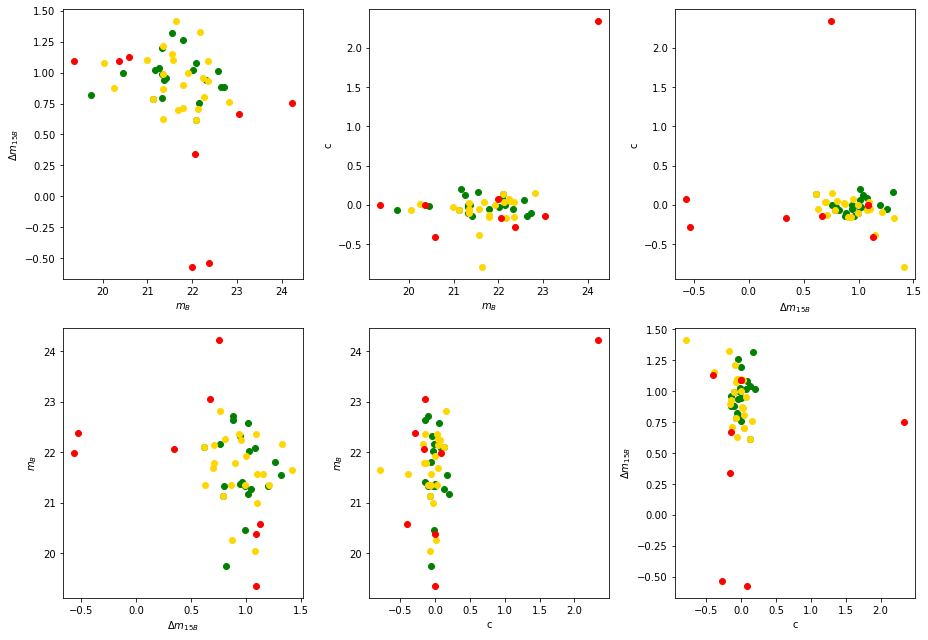

In [146]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(good_mb, good_delta_m15b, color='green')
ax[0,0].scatter(maybe_mb, maybe_delta_m15b, color='gold')
ax[0,0].scatter(bad_mb, bad_delta_m15b, color='red')
ax[0,0].set_xlabel("$m_{B}$")
ax[0,0].set_ylabel("$\Delta m_{15B}$")

ax[0,1].scatter(good_mb, good_c, color='green')
ax[0,1].scatter(maybe_mb, maybe_c, color='gold')
ax[0,1].scatter(bad_mb, bad_c, color='red')
ax[0,1].set_xlabel("$m_{B}$")
ax[0,1].set_ylabel('c')

ax[0,2].scatter(good_delta_m15b, good_c, color='green')
ax[0,2].scatter(maybe_delta_m15b, maybe_c, color='gold')
ax[0,2].scatter(bad_delta_m15b, bad_c, color='red')
ax[0,2].set_xlabel("$\Delta m_{15B}$")
ax[0,2].set_ylabel('c')

ax[1,0].scatter(good_delta_m15b, good_mb, color='green')
ax[1,0].scatter(maybe_delta_m15b, maybe_mb, color='gold')
ax[1,0].scatter(bad_delta_m15b, bad_mb, color='red')
ax[1,0].set_xlabel("$\Delta m_{15B}$")
ax[1,0].set_ylabel("$m_{B}$")

ax[1,1].scatter(good_c, good_mb, color='green')
ax[1,1].scatter(maybe_c, maybe_mb, color='gold')
ax[1,1].scatter(bad_c, bad_mb, color='red')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel("$m_{B}$")

ax[1,2].scatter(good_c, good_delta_m15b, color='green')
ax[1,2].scatter(maybe_c, maybe_delta_m15b, color='gold')
ax[1,2].scatter(bad_c, bad_delta_m15b, color='red')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel("$\Delta m_{15B}$")


fig.tight_layout()
fig.show()

#### Comparison between abs mag $M_{B}$, and original & converted parameters

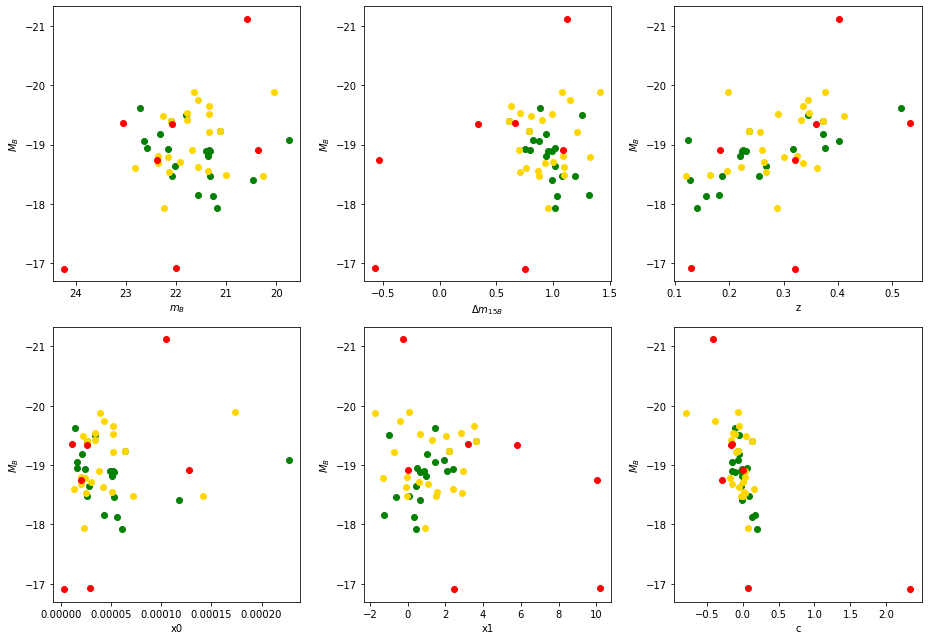

In [148]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(good_mb, good_abs_mag, color='green')
ax[0,0].scatter(maybe_mb, maybe_abs_mag, color='gold')
ax[0,0].scatter(bad_mb, bad_abs_mag, color='red')
ax[0,0].set_xlabel("$m_{B}$")
ax[0,0].set_ylabel("$M_{B}$")
ax[0,0].invert_yaxis()
ax[0,0].invert_xaxis()

ax[0,1].scatter(good_delta_m15b, good_abs_mag, color='green')
ax[0,1].scatter(maybe_delta_m15b, maybe_abs_mag, color='gold')
ax[0,1].scatter(bad_delta_m15b, bad_abs_mag, color='red')
ax[0,1].set_xlabel("$\Delta m_{15B}$")
ax[0,1].set_ylabel("$M_{B}$")
ax[0,1].invert_yaxis()

ax[0,2].scatter(good_z, good_abs_mag, color='green')
ax[0,2].scatter(maybe_z, maybe_abs_mag, color='gold')
ax[0,2].scatter(bad_z, bad_abs_mag, color='red')
ax[0,2].set_xlabel('z')
ax[0,2].set_ylabel("$M_{B}$")
ax[0,2].invert_yaxis()

ax[1,0].scatter(good_x0, good_abs_mag, color='green')
ax[1,0].scatter(maybe_x0, maybe_abs_mag, color='gold')
ax[1,0].scatter(bad_x0, bad_abs_mag, color='red')
ax[1,0].set_xlabel('x0')
ax[1,0].set_ylabel("$M_{B}$")
ax[1,0].invert_yaxis()

ax[1,1].scatter(good_x1, good_abs_mag, color='green')
ax[1,1].scatter(maybe_x1, maybe_abs_mag, color='gold')
ax[1,1].scatter(bad_x1, bad_abs_mag, color='red')
ax[1,1].set_xlabel('x1')
ax[1,1].set_ylabel("$M_{B}$")
ax[1,1].invert_yaxis()

ax[1,2].scatter(good_c, good_abs_mag, color='green')
ax[1,2].scatter(maybe_c, maybe_abs_mag, color='gold')
ax[1,2].scatter(bad_c, bad_abs_mag, color='red')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel("$M_{B}$")
ax[1,2].invert_yaxis()

fig.tight_layout()
fig.show();

### Other Analysis
> **True Good:** Candidates that had normal parameter/error values AND had good fits
> **True Bad:** Candidates that had outlying parameters/large errors AND had bad fits
> **False_Good:** Candidates that had normal parameter/error values AND had bad fits
> **False_Bad:** Candidates that had outlying parameters/large errors AND had good fits

In [149]:
# this can't really include the 'maybe' candidates

true_good = [0,3,6,7,8,9,10,16,17,18,19,24,26,29,44]
true_bad = [13,15,30,40,42,45,47,49]
false_good = [] #all 'bad' rated candidates were originally 'bad' from parameter/errors
false_bad = [5,14,20,50]